## **CHAPTER 6 학습관련 기술들**

**이번 장에서 다룰 주제는 가중치 매개변수의 최적값을 탐색하는 최적화 방법, 가중치 매개변수 초깃값, 하이퍼파라미터 설정 방법 등, 모두가 신경망 학습에서 중요한 주제이다.**

**오버피팅의 대응책인 가중치 감수와 드롭아웃 등의 정규화 방법도 간략히 설명하고 구현해본다. 마지막으로 최근 많은 연구에서 사용하는 배치 정규화도 짧게 알아본다.**

## **6.1 매개변수 갱신**

**신경망 학습의 목적은 손실 함수의 값을 가능한 한 낮추는 매개변수를 찾는 것이었다. 이는 곧 매개변수의 최적값을 찾는 문제이며, 이러한 문제를 푸는 것을 최적화(optimization)라 한다.**

> - **하지만 매개변수 공간은 매우 넓고 복잡해서 최적의 솔루션을 찾기 힘들고, 심층 신경망에서는 매개변수의 수가 엄청 많아져서 쉽지 않다.**

**우리는 지금까지 최적의 매개변수 값을 찾는 단서로 매개변수의 기울기(미분)를 이용했다. 매개변수의 기울기를 구해, 기울어진 방향으로 매개변수 값을 깅신하는 일을 몇 번이고 반복해서 점점 최적의 값에 다가갔다. 이것이 확률적 경사 하강법(SGD)이란 단순한 방법인데, 매개변수 공간을 무작정 찾는 것보다 '똑똑한' 방법이다.**

### **6.1.1 모험가 이야기**

**모험가는 주위 경치는 볼 수 없지만 지금 서 있는 땅의 기울기는 알 수 있다. 그래서 지금 서 있는 장소에서 가장 크게 기울어진 방향으로 가는 것이 SGD의 전략이다.**

### **6.1.2 확률적 경사 하강법**

**SGD의 수식으로는 다음과 같이 쓸 수 있다.**

![test](./img/SGD.png)

**여기에서 W는 갱신할 가중치 매개변수이고 ∂L/∂W은 W에 대한 손실 함수의 기울기이다. η는 학습률을 의미하는데, 실제로는 0.01이나 0.001과 같은 값을 미리 정해서 사용한다. 또 <-는 우변의 값을 좌변의 값을 갱신한다는 뜻이다.**

In [1]:
# lr은 learning rate(학습률)을 뜻한다. 이 학습률은 인스턴스 변수로 유지한다.
# update(params, grads) 메서드는 SGD 과정에서 반복해서 불린다.
# 인수인 params와 grads는 (지금까지 신경망 구현과 마찬가지로) 딕셔너리 변수이다.
# params['W1'], grads['W1'] 등과 같이 각각 가중치 매개변수와 기울기를 저장하고 있다.
class SGD:
    def __init__(self,lr = 0.01):
        self.lr = lr
        
    def update(self,params,grads):
        for key in params.keys():
            params[key] -= lr * grads[key]

### **6.1.3 SGD의 단점**

**SGD는 단순하고 구현도 쉽지만, 문제에 따라서는 비효율적일 때가 있다. 이번 절에서는 SGD의 단점을 알아보고자 다음 함수의 최솟값을 구하는 문제를 생각해본다.**

![test](./img/단점.png)
![test](./img/단점그래프.png)

**이 함수는 왼쪽 그림과 같이 '밥그릇'을 x축 방향으로 늘인 듯한 모습이고, 실제로 그 등고선은 오른쪽 그림과 같이 x축 방향으로 늘인 타원으로 되어있다.**


![test](./img/단점기울기.png)


**위 식의 함수의 기울기를 그려보면 위 그림 처럼 되는데, 이 기울기는 y축 방향은 크고 x축 방향은 작다는 것이 특징이다. 말하자면 y축 방향은 가파른데 x축 방향은 완만한 것이다. 또, 여기서 주의할 점으로는 최솟값이 되는 장소는 (x,y) = (0,0) 이지만, 그림이 보여주는 기울기 대부분은 (0,0) 방향을 가리키지 않는다는 것이다.**

![test](./img/SGD최적화.png)

**SGD는 위 그림과 같이 심하게 굽이진 움직임을 보여준다. 상당히 비효율적이다. 즉, SGD의 단점은 비등방성(anisotropy)함수(방향에 따라 성절, 즉 여기에서는 기울기가 달라지는 함수)에서는 탐색 경로가 비효율적이라는 것이다.**

> - **이럴 때는 SGD 같이 무작정 기울어진 방향으로 진행하는 단순한 방식보다 더 영리한 묘안이 간절해진다. 또한, SGD가 지그재그로 탐색하는 근본 원인은 기울어진 방향이 본래의 최솟값과 다른 방향을 가리켜서라는 점도 생각해볼 필요가 있다.**

### **6.1.4 모멘텀**

**모멘텀(Momentum)은 '운동량'을 뜻하는 단어로, 물리와 관계가 있다. 모멘텀 기법은 수식으로는 다음과 같이 쓸 수 있다.**

![test](./img/모멘텀.png)

**SGD처럼 여기에서도 W는 갱신할 가중치 매개변수, ∂L/∂W는 W에 대한 손실함수의 기울기, η는 학습률이다.**

**V라는 변수가 새로 나오는데, 이는 물리에서 말하는 속도(velocity)에 해당한다. 즉, 기울기 방향으로 힘을 받아 물체가 물체가 가속된다는 물리법칙을 나타낸다.**

![test](./img/모멘텀이미지.png)

**또, αv항은 물체가 아무런 힘을 받지 않을때 서서히 하강시키는 역할을 한다.(α는 0.9 등의 값으로 설정) 물리에서의 지면 마찰이나 공기 저항에 해당한다.**

In [2]:
import numpy as np

In [3]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr # learning rate
        self.momentum = momentum # momentum
        self.v = None # velocity
        
    def update(self, params, grads): # parameter, gradient
        # v 초기화 일때 설정 즉, 크기에 맞게 0으로 맞춰줌
        if self.v is None:
            self.v = {} # dict 
            for key, val in params.items():
                # value의 shape만큼 zero 행렬 생성
                params[key] = np.zeros_like(val)
        # 두번째 epochs 부턴 v.self 값이 None이 아니므로 if문을 생략한채 바로 두번째 for문으로 이동
        for key in params.keys(): # 파라미터의 key값을 순차적으로 넘겨준다.
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key] # v <- αV - η*(∂L/∂W)
            params[key] += self.v[key] # W <- W + v

![test](./img/모멘텀경로.png)

**그림과 같이 갱신 경로는 공이 그릇 바닥을 구르듯 움직인다. SGD와 비교하면 지그재그 정도가 덜한 것을 알 수 있다.**

> - **이는 X축의 힘은 아주 작지만 방향은 변하지 않아서 한 방향으로 일정하게 가속하기 때문이다.**

**거꾸로 y축의 힘은 크지만 위아래로 번갈아 받아서 상충하여 y축 방향의 속도는 안정적이지 않다.**

> - **전체적으로는 SGD보다 x축 방향으로 빠르게 다가가 지그재그 움직임이 줄어든다.**


### **6.1.5 AdaGrad**

**신경망 학습에서는 학습률 값이 중요하다. 이 값이 너무 작으면 학습 시간이 너무 길어지고, 반대로 너무 크면 발산하여 학습이 제대로 이뤄지지 않는다.**

**이 학습률을 정하는 효과적 기술로 학습률 감소(learning rate decay)가 있다. 이는 학습을 진행하면서 학습률을 점차 줄여가는 방법이다. 처음에는 크게 학습하다가 조금씩 작게 학습한다는 얘기로, 실제 신경망 학습에 자주 사용된다.**

![test](./img/그레이드.png)


**여기에서는 새로 h라는 변수가 추가되는데, h는 위 식에서 보듯 기존 기울기 값을 제곱하여 계속 더해준다. 그리고 매개변수를 갱신할 때 1/√h)을 곱해 학습률을 조정한다.**

**매개변수의 원소 중에서 많이 움직인 (크게 갱신된) 원소는 학습률이 낮아진다는 뜻인데, 다시 말해 학습률 감소가 매개변수의 원소마다 다르게 적용됨을 뜻한다.**

> - **AdaGrad는 과거의 기울기를 제곱하여 계속 더해간다. 그래서 학습을 진행할수록 갱신 강도가 약해진다. 실제로 무한히 계속 학습한다면 어느 순간 갱신량이 0이 되어 전혀 갱신되지 않게 된다. 이 문제를 개선한 기법으로서 RMSProp라는 방법이 있다. RMSProp은 과거의 모든 기울기를 균일하게 더해가는 것이 아니라, 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영한다. 이를 지수이동평균(Exponential Moving Average,EMA)이라 하여, 과거 기울기의 반영 규모를 기하급수적으로 감소시킨다.**

In [4]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

![test](./img/아다그레이드.png)


**위 그림처럼 최솟값을 향해 효율적으로 움직이는 것을 알 수 있다.**

> - **y축 방향은 기울기가 커서 처음에는 크게 움직이지만, 그 큰 움직임에 비례해 갱신 정도도 큰 폭으로 작아지도록 조정된다.**

> - **그래서 y축 방향으로 갱신 강도가 빠르게 약해지고, 지그재그 움직임이 줄어든다.**

### **6.1.6 Adam**

**AdaGrad와 Momentum을 융합한 기법이다.**

> - **즉, 공이 그릇 바닥을 구르는 듯한 움직임과 매개변수의 원소마다 적응적으로 갱신 정도를 조정한다.**

> - **또한, 하이퍼파라미터의 '편향 보정'이 진행된다는 점도 Adam의 특징이다.**

![test](./img/아담.png)

**위 그림과 같이 Adam 갱신 과정도 그릇 바닥을 구르듯 움직인다. 모멘텀과 비슷한 패턴인데, 모멘텀 때보다 공의 좌우 흔들림이 적다. 이는 학습의 갱신 강도를 적응적으로 조정해서 얻는 혜택이다.**

> - **Adam은 하이퍼파라미터를 3개를 설정한다. 하나는 지금까지의 학습률, 나머지 두 개는 일차 모멘터용 계수 β1과 이차 모멘터용 계수 β2이다. 논문에 따르면 기본 설정값은 β1은 0.9, β2는 0.999이며, 이 값이면 많은 경우에 좋은 결과를 얻을 수 있다.**

In [4]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

### **6.1.7 어느 갱신 방법을 이용할 것인가?**

**사용한 기법에 따라 갱신 경로가 다르다. 그림만 보면 AdaGrad가 가장 나은 것 같은데, 사실 그 결과는 풀어야 할 문제가 무엇이냐에 따라 달라지므로 주의해야 한다. 또, 당연하지만 (학습률 등의) 하이퍼파라미터를 어떻게 설정하느냐에 따라서도 결과가 바뀐다.**

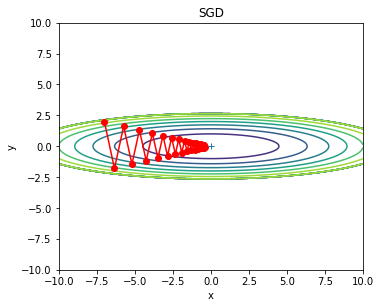

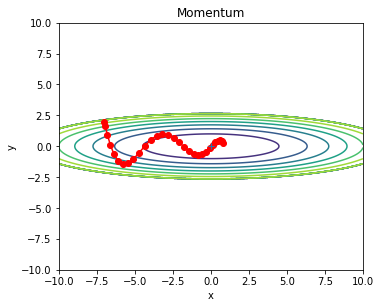

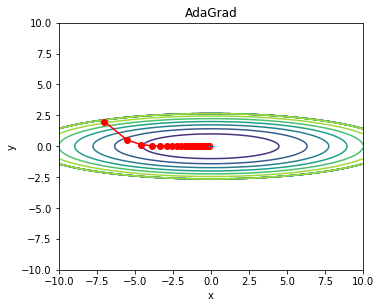

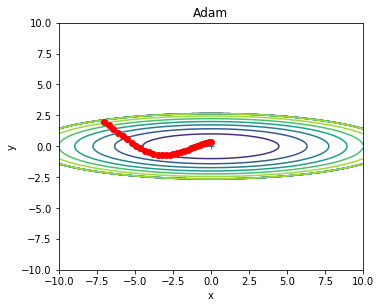

In [14]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

**SGD, 모멘텀, AdaGrad, Adam의 네 후보 중 어느 것을 채택하면 좋을지는 유감스럽게도 모든 문제에서 항상 뛰어난 기법이라는 것은 없다. 각자의 장단이 있어 잘 푸는 문제와 서툰 문제가 있다.**

**지금도 많은 연구에서 SGD를 사용하고 있다. 모멘텀과 AdaGrad도 시도해볼 만한 가치가 충분하다. 요즘에는 많은 분이 Adam에 만족해하며 쓰는 것 같다.**

### **6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교**

**손글씨 숫자 인식을 대상으로 지금까지 설명한 네 기법을 비교해본다.**

===========iteration:0===========
SGD:2.321973922359933
Momentum:2.3856240225439
AdaGrad:2.0940022566258185
Adam:2.208391699843439
===========iteration:100===========
SGD:1.2330430507917454
Momentum:0.44116004483671545
AdaGrad:0.19183441842217863
Adam:0.35971826679004926
===========iteration:200===========
SGD:0.6488209663749549
Momentum:0.22957439495734197
AdaGrad:0.10482925463662246
Adam:0.1858231667678435
===========iteration:300===========
SGD:0.4937715215890463
Momentum:0.2199517017451822
AdaGrad:0.10224512921960859
Adam:0.15729572930250746
===========iteration:400===========
SGD:0.3492645950169868
Momentum:0.1299625831722544
AdaGrad:0.06103825587468633
Adam:0.11140803611094921
===========iteration:500===========
SGD:0.4445731687883916
Momentum:0.20385862426160933
AdaGrad:0.11596458315312431
Adam:0.13102479204737155
===========iteration:600===========
SGD:0.3071037097013969
Momentum:0.10138661115285548
AdaGrad:0.04786777152307523
Adam:0.06383835355650147
===========iteration:700==

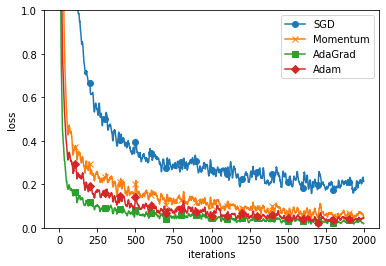

In [15]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

**이 실험은 각 층이 100개의 뉴런으로 구성된 5층 신경망에서 ReLU를 활성화 함수로 사용해서 측정했다. 결과를 보면 SGD의 학습 진도가 가장 느리고 나머지 세 기법의 진도는 비슷한데, 잘 보면 AdaGrad가 조금 더 빠른 것 같다. 이 실험에서 주의할 점은 하이퍼파라미터인 학습률과 신경망의 구조(층 깊이 등)에 따라 결과가 달라진다는 것이다.**

> - **다만 일반적으로 SGD 보다 다른 세 기법이 빠르게 학습하고, 때로는 최종 정확도도 높게 나타난다.**

## 6.2 가중치 초깃값

- 신경망 학습에서 특히 중요한 것이 가중치의 초깃값이다.
- 가중치의 초깃값을 무엇으로 설정 하느냐가 신경망 학습의 성패가 가르는 일이 실제로 자주 있었다.

## 6.2.1 초기값을 0으로 하면?

- 오버피팅을 억제해 범용 성능을 높이는 테크닉인 가중치 감소 기법
- 가중치 감소는 간단히 말하자면 가중치 매개변수의 값이 작아지도록 학습하는 방법이다.
> - 즉, 가중치 값을 작게 하여 오버피팅이 일어나지 않게 하는 것
- 가중치를 작게 만들고 싶으면 초깃값도 최대한 작은 값에서 시작하는 것이 정공법이다.
> - 사실 지금까지 가중치의 초깃값은 0.01Xnp.random.randn(10,100)처럼 정규분포에서 생성되는 값을 0.01배 한 작은 값(표준편차가 0.01인 정규분포)을 사용
> - 그렇다고 가중치를 모두 0에서 부터 시작하면 오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기때문에 학습이 올바로 이루어지지 않는다.
> - 따라서 '가중치'가 고르게 되어버리는 상황을 막으려면 초기값을 무작위로 설정해야한다.

## 6.2.2 은닉층의 활성화값 분포

- 은닉층의 활성화값(활성화 함수의 출력 데이터)의 분포를 관찰하면 중요한 정보를 얻을 수 있다.
- 활성화 함수로 시그모이드 함수를 사용하는 5층 신경망에 무작위로 생성한 입력 데이터를 흘리며 각 층의 활성화값 분포를 히스토그램으로 그린다.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [7]:
x = np.random.randn(1000,100) # 1000개의 데이터
node_num = 100 # 각 은닉층의 노드 수
hidden_layer_size = 5 # 은닉층이 5개
activations = {} # 이곳에 활성화 결과(활성화 값)을 저장

In [8]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1] # 전 층의 활성화 함수 값을 입력 데이터로 사용
    w = np.random.randn(node_num,node_num) * 1 # 표준편차가 1인 정규분포
    a = np.dot(x,w)
    z = sigmoid(a)
    activations[i] = z # 활성화 함수 값 저장

- 층이 5개가 있으며, 각 층의 뉴련은 100개씩이다.
- 입력 데이터로 1,000개의 데이터를 정규분포로 무작위 생성하여 5층 신경망에 흘리는데
- 활성화 함수로는 시그모이드를 사용하고 활성화 결과를 activations 변수에 저장

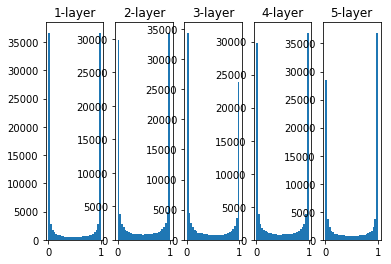

In [9]:
for i, a in activations.items(): # key값 value값을 넘겨준다.
    plt.subplot(1,len(activations),i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(),30,range=(0,1)) # 히스토그램
plt.show()

- 각 층의 활성화값들이 0과 1에 치우쳐 분포되어 있다.
- 여기서 사용한 시그모이드 함수는 그 출력이 0 또는 1에 가까워지자 그 미분은 0에 다가간다.
- 그래서 데이터가 0과 1에 치우쳐 분포하게 되면 역전파의 기울기 값이 점점 작아지다가 사라진다. 이것이 기울기 소실이라 알려진 문제이다.

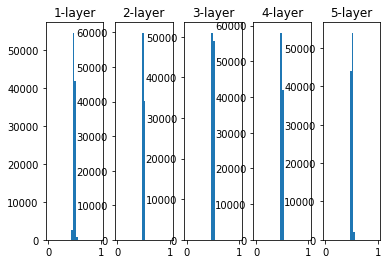

In [10]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1] # 전 층의 활성화 함수 값을 입력 데이터로 사용
    w = np.random.randn(node_num,node_num) * 0.01 # 표준편차가 0.01인 정규분포
    a = np.dot(x,w)
    z = sigmoid(a)
    activations[i] = z # 활성화 함수 값 저장
    
for i, a in activations.items(): # key값 value값을 넘겨준다.
    plt.subplot(1,len(activations),i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(),30,range=(0,1)) # 히스토그램
plt.show()

- 표준편차를 0.01로 한 정규분포의 경우 각 층의 활성화값 분포는 0.5부근에 집중되었다.
- 기울기 소실의 문제를 일으키진 않지만, 활성화값들이 치우쳤다는 것은 표현력 관점에서는 큰 문제가 있는 것이다.
> - 다수의 뉴런이 거의 같은 값을 출력하고 있으니 뉴런을 여러 개 둔 의미가 없어진다는 뜻이다.
> - 즉, 뉴런 100개가 거의 같은 값을 출력한다면 뉴런1개짜리와 별반 다를게 없다.
- 그래서 활성화값들이 치우치면 표현력을 제한한다는 관정에서 문제가 된다.
- 각 층의 활성화값은 적당히 고루 분포되어야 한다. 층과 층 사이에 적당하게 다양한 데이터가 흐르게 해야 신경망 학습이 효율적으로 이뤄지기 때문이다. 반대로 치우친 데이터가 흐르면 기울기 소실이나 표현력 제한 문제에 빠져서 학습이 잘 이워지지 않는 경우가 생긴다.
---------

- Xavier 초기값은 일반적인 딥러닝 프레임워크들이 표준적으로 이용하고 있다.
- 이 논문은 각 층의 활성화값들을 광범위하게 분포시킬 목적으로 가중치의 적절한 분포를 찾고자 했다.

![test](./img/초기값.png)

- 초기값의 표준편차가 1/√n이 되도록 설정 (n=앞층의 노드수)
- Xavier 초기값을 사용하면 앞 층에 노드가 많을수록 대상 노드의 초기값으로 설정하는 가중치가 좁게 퍼진다.

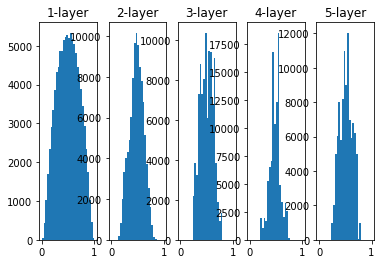

In [11]:
input_data = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1] # 전 층의 활성화 함수 값을 입력 데이터로 사용
    w = w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    a = np.dot(x,w)
    z = sigmoid(a)
    activations[i] = z # 활성화 함수 값 저장
    
for i, a in activations.items(): # key값 value값을 넘겨준다.
    plt.subplot(1,len(activations),i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(),30,range=(0,1)) # 히스토그램
plt.show()

- 이 결과를 보면 층이 깊어지면서 형태가 다소 일그러지지만, 앞에서 본 방식보다는 확실히 넓게 분포됨을 알 수 있다.
- 각 층의 흐르는 데이터는 적당히 퍼져 있으므로, 시그모이드 함수의 표현력도 제한받지 않고 학습이 효율적으로 이뤄질 것으로 기대된다.
- 오른쪽으로 갈수록 약간씩 일그러짐은 sigmoid함수 대신 tanh 함수(쌍곡선 함수)를 이용하면 개선된다. 실제로 tanh 함수를 이용하면 말끔한 종 모양으로 분포된다. tanh 함수도 sigmoid와 같이 S자 모양 곡선 함수이지만 tanh 함수가 원점(0,0)에서 대칭인 S곡선인 반면, sigmoid 함수는 0.05에서 대칭인 S곡선이다. 활성화 함수용으로는 원점에서 대칭인 함수가 바람직하다고 알려져 있다.

## 6.2.3 ReLU를 사용할 때의 가중치 초깃값

- Xavier 초기값은 활성화 함수가 선형인 것을 전제로 이끈 결과이다.
- sigmoid 함수와 tanh 함수는 좌우 대칭이라 중앙 부근이 선형인 함수로 볼 수 있다.
> - 따라서 Xavier 초깃값이 적당하다.
- 반면 ReLU를 이용할 때는 ReLU에 특화된 초깃값을 이용하라고 권장한다. 
> - 이 특화된 초깃값을 찾아낸 카이밍 히의 이름을 따 He 초깃값이라 한다.
> - He 초깃값은 앞 계층의 노드가 n개 일때, 표준편차가 (√2/√n)인 정규분포를 사용한다.
> - ReLU는 음의 영역이 0이라서 더 넓게 분포시키기 위해 2배의 계수가 필요하다고 직감적으로 해석 할 수 있다.

In [12]:
def relu(x):
    return np.maximum(0,x) # maximum은 두 입력 중 큰 값을 선택해 반환하는 함수
def tanh(x):
    return np.tanh(x)

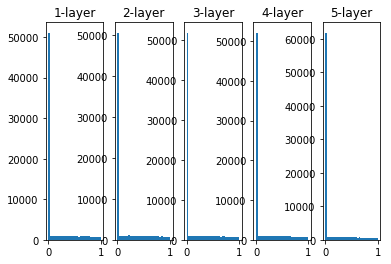

In [13]:
input_data = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1] # 전 층의 활성화 함수 값을 입력 데이터로 사용
    w = w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
    a = np.dot(x,w)
    z = relu(a)
    activations[i] = z # 활성화 함수 값 저장
    
for i, a in activations.items(): # key값 value값을 넘겨준다.
    plt.subplot(1,len(activations),i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(),30,range=(0,1)) # 히스토그램
plt.show()

![test](./img/초깃값.png)

- 결과를 보면 std=0.01일때의 각 층의 활성화값들은 아주 작은 값들이다.
> - 신경망에 아주 작은 데이터가 흐른다는 것은 역전파 때 가중치의 기울기 역시 작아진다는 뜻이다.
- Xavier 결과를 보면 층이 깊어지면서 치우침이 조금씩 커진다.
> - 실제로 층이 깊어지면 활성화값들의 치우침도 커지고, 학습할 때 기울기 소실 문제를 일으킨다.
- 마지막으로 He초기값은 모든 층에서 균일하게 분포되었다. 층이 깊어져도 분포가 균일하게 유지되기에 역전파 때도 적절한 값이 나올 것으로 기대할 수 있다.

## 6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교

![test](./img/mnist.png)

- 층별 뉴런 수가 100개인 5층 신경망에서 활성화 함수로 ReLU를 사용
- std = 0.01일 때는 학습이 전혀 이뤄지지 않는다. 
> - 앞서 설명한 것처럼 순전파 때 너무 작은 값(0 근처로 밀집한 데이터)이 흐르기 때문이다.
> - 그로 인해 역전파 때의 기울기도 작아져 가중치가 거의 갱신되지 않는 것이다.
- Xavier와 He 초깃값의 경우는 학습이 순조롭게 이뤄지고 있다. 다만 학습 진도는 He 초깃값 쪽이 더 빠르다.

-----------

- 가중치의 초깃값은 신경망 학습에 아주 중요한 포인트이다.가중치의 초깃값에 따라 신경망 학습의 성패가 갈리는 경우가 많다. 초깃값의 중요성은 간과하기 쉬운 부분이지만 어떤 일이든 시작이 중요한 법이다.

## 6.3 배치 정규화

- 각 층의 활성화값 분포를 관찰하면서, 가중치의 초깃값을 적절히 설정하면 각 층의 활성화값 분포가 적당히 퍼지면서 학습이 원활하게 수행됨을 배웠다.
- 각층의 활성화를 적당히 퍼뜨리도록 강제하는 아이디어로 출발한 방법이 배치 정규화(Batch Normalization)이다.

## 6.3.1 배치 정규화 알고리즘

- 배치 정규화가 주목 받는 이유
> - 학습을 빨리 진행할 수 있다.(학습 속도 개선)
> - 초깃값에 크게 의존하지 않는다.(골치 아픈 초깃값 선택을 하지 않아도 됨)
> - 오버피팅을 억제한다. (드롭아웃 등의 필요성 감소)

![test](./img/배치정규화.png)

- 데이터 분포를 정규화하는 '배치 정규화 계층'을 신경망에 삽입한다.

![test](./img/배치정규화수식.png)

- 배치 정규화는 그 이름과 같이 학습 시 미니배치를 단위로 정규화한다. 구체적으로는 데이터의 분포가 평균이 0, 분산이 1이 되도록 정규화합니다.
- B ={x1,x2,,,xm}이라는 m개의 입력데이터의 평균과 분산을 구하고 맨 아래 ε은 작은 값을 주어 0으로 나누는 사태를 예방하는 역할을 한다.
- 이 처리를 활성화 함수의 앞(혹은 뒤)에 삽입 함으로써 데이터 분포가 덜 치우치게 할 수 있다.
- 배치 정규화 계층마다 이 정규화된 데이터에 고유한 확대(Scale)와 이동(shift)변환을 수행
> - 수식: yi <- γxi+β
> - γ가 확대를, β가 이동을 담당한다. 두 값은 처음에는 γ = 1, β = 0 부터 시작하고 학습하면서 적합한 값으로 조정해준다.

![test](./img/배치정규화그래프.png)

![test](./img/배치정규화효과.png)

- 위 그림과 같이 배치 정규화가 학습을 빨리 진전시키고 있다.
- 이 처럼 거의 모든 경우에서 배치 정규화를 사용할 때의 학습 진도가 빠른 것으로 나타나면 배치 정규화를 사용하면 학습이 빨라지며, 가중치 초기갓값에 크게 의존하지 않아도 된다.

## 6.4 바른 학습을 위해

- 오버피팅이란 신경망이 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에는 제대로 대응하지 못하는 상태를 말한다.
- 오버피팅은 주로 다음의 두 경우에 일어난다.
> - 매개변수가 많고 표현력이 높은 모델
> - 훈련 데이터가 적음

## 6.4.1 가중치 감소

- 오버피팅 억제용으로 예로부터 많이 이용해온 방법 중 가중치 감소(Weight decay)라는 것이 있다.
- 이는 학습 과정에서 큰 가중치에 대해서는 그에 상응하는 페널티를 부과하여 오버피팅을 억제하는 방법이다.
> - 원래 오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많기 때문
> - L2노름을 가정하면 가중치가 W라 하면 L2노름에 따른 가중치 감소는 1/2λW^2이 되고, 이를 손실 함수에 더 한다.
> - λ는 정규화의 세기를 조절하는 하이퍼파라미터이다. λ크게 할수록 큰 가중치에 대한 패널티가 커진다.

## 6.4.2 드롭아웃
- 신경망 모델이 복잡해지면 가중치 감소만으로는 대응하기 어려워진다. 이럴 때는 흔히 드롭아웃(Dropout)이라는 기법을 이용한다.
- 드롭아웃은 뉴런을 임의로 삭제하면서 학습하는 방법이다.
> - 훈련 때 은닉층의 뉴런을 무작위로 골라 삭제한다.
> - 삭제된 뉴런은 아래 그림과 같이 신호를 전달하지 않게 된다.
> - 훈련 때는 데이터를 흘릴 때마다 삭제할 뉴런을 무작위로 선택하고, 시험 때는 모든 뉴런에 신호를 전달합니다.
>> - 단, 시험 때는 각 뉴런의 출력에 훈련 때 삭제한 비율을 곱하여 출력

![test](./img/드롭아웃.png)

In [31]:
class Dropout:
    def __init__(self,dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self,x,train_flg = True):
        
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio 
            # self.mask는 x와 형상이 같은 배열을 무작위로 생성하고, 
            # 그 값이 dropout_ratio보다 큰 원소만 True 설정
            return x * self.mask # True 위치의 값만 계산되서 다음으로 흘리고 False는 0
        else:
            return x * (1.0 - self.dropout_ratio)
    def backward(self,dout):
        return dout * self.mask

- 여기에서 핵심은 훈련 시에는 순전파 때마다 self.mask에 삭제할 뉴런을 False로 표시한다는 것이다.
- 즉, 순전파 때 신호를 통과시키는 뉴런은 역전파 때도 신호를 그대로 통과시키고, 순전파 때 동과시키지 않은 뉴런은 역전파 때도 신호를 차단

## 6.5 적절한 하이퍼파라미터 값 찾기 

- 신경망에는 하이퍼파라미터가 다수 등장한다.
> - 뉴런 수, 배치 크기, 매개변수 갱신 시의 학습률, 가중치 감소 등
- 이러한 하이퍼파라미터의 값을 적절히 설정하지 않으면 모델의 성능이 크게 떨어지기도 한다.
> - 이번 절에선 하이퍼파라미터의 값을 최대한 효율적으로 탐색하는 방법을 찾는다.

## 6.5.1 검증 데이터

- 앞으로 하이퍼파라미터를 다양한 값으로 설정하고 검증할 텐데, 여기서 주의할 점은 하이퍼파라미터의 성능을 평가할 때는 시험 데이터를 사용해서는 안 된다는 점 이다.
- 하이퍼파라미터를 조정할 때는 하이퍼파라미터 전용 확인 데이터가 필요한데 이를 검증 데이터(Validation data)라 부른다.
> - 즉, 하이퍼파라미터의 적절성을 평가하는 데이터
>> - 훈련데이터 : 매개변수 학습
>> - 검증데이터 : 하이퍼파라미터 성능 평가
>> - 시험데이터 : 신경망의 범용 성능 평가 

In [32]:
import sys,os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

In [36]:
(x_train,t_train), (x_test,t_test) = load_mnist()

In [38]:
def shuffle_dataset(x, t):
    """데이터셋을 뒤섞는다.

    Parameters
    ----------
    x : 훈련 데이터
    t : 정답 레이블
    
    Returns
    -------
    x, t : 뒤섞은 훈련 데이터와 정답 레이블
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

In [39]:
x_train, t_train = shuffle_dataset(x_train,t_train)
# 분리하기전 입력 데이터와 정답 레이블을 뒤섞는다.

In [42]:
vaildation_rate = 0.2
vaildation_num = int(x_train.shape[0] * vaildation_rate) # 12,000

x_val = x_train[:vaildation_num]
t_val = t_train[:vaildation_num]
x_train = x_train[vaildation_num:]
t_train = t_train[vaildation_num:]

## 6.5.2. 하이퍼파라미터 최적화

- 하이퍼파라미터를 최적화할 때의 핵심은 하이퍼파라미터의 최적 값이 존재하는 범위를 조금씩 줄여간다는 것이다.
- 범위를 조금씩 줄이려면 우선 대략적인 범위를 설정하고 그 범위에서 무작위로 하이퍼파라미터 값을 골라낸(샘플링) 후, 그 값으로 정확도를 평가한다.
- 정확도를 잘 살피면서 이 작업을 여러 번 반복하며 하이퍼파라미터의 '최적 값'의 범위를 좁혀가는 것 입니다.
> - 신경망의 하이퍼파라미터 최적화에서는 그리드 서치 같은 규칙적인 탐색보다는 무작위로 샘플링해 탐색하는 편이 좋은 결과를 낸다고 알려져있다. 이는 최종 정확도에 미치는 영향력이 하이퍼파라미터마다 다르기 때문
- 범위는 대략적으로 지정하는 것이 효과적이다.
> - 실제로도 0.001에서 1.000 사이 (10e-3 ~ 10^3)와 같이 10의 거듭제곱 단위로 범위로 지정한다. 이를 로그 스케일로 지정한다고 한다.
- 하이퍼파라미터를 최적화할 때는 딥러닝 학습에는 오랜 시간 (몇일이나 몇 주 이상) 걸린다는 점을 기억해야 한다.
- 따라서 학습을 위한 에폭을 작게 하여, 1회평가에 걸리는 시간을 단축시키고 아닌거 같으면 일찍 포기하는게 좋다.

## 정리

- 0단계: 하이퍼파라미터 값의 범위를 설정
- 1단계: 설정된 범위에서 하이퍼파라미터의 값을 무작위 추출
- 2단계: 1단계에서 샘플링한 하이퍼파라미터 값을 사용하여 학습하고, 검증 데이터로 정확도를 평가(단, 에폭은 작게 설정)
- 3단계: 1단계와 2단계를 특정 횟수 (100회 등) 반복하며, 그 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힌다.
- 마지막으로 어느 정도 좁아지면 그 압춥한 범위에서 값을 하나 골라낸다.
> - 실용적인 방법이지만 더 세련된 기법을 원한다면 베이즈 최적화를 공부하라

![test](./img/최적화.png)